## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
from statsmodels.api import OLS

# SKLearn stuff
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,\
    MinMaxScaler,\
    StandardScaler,\
    PolynomialFeatures,\
    OrdinalEncoder,\
    OneHotEncoder,\
    power_transform
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from yellowbrick.regressor import ResidualsPlot

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

# Header cleaning. More precautionary than anything else
df.columns = [x.strip().lower().replace(' ', '').replace('-', '')
              for x in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Remove outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x20360d09100>,
 'caps': [<matplotlib.lines.Line2D at 0x20360d097c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20360cf1d60>],
 'medians': [<matplotlib.lines.Line2D at 0x20360d09e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x20360d11220>],
 'means': []}

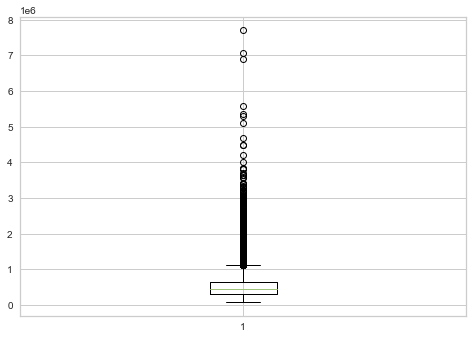

In [4]:
plt.boxplot(df.price)

In [5]:
# Zach's code
price_q75, price_q25 = np.percentile(df['price'],[75,25])
intr_qrt = price_q75-price_q25
upper_price = price_q75 + (1.5*intr_qrt)
lower_price = price_q25 - (1.5*intr_qrt)
lower_price, upper_price
df = df[df['price'] <= upper_price]
df = df[df['price'] >= lower_price]

In [6]:
# Removing outliers
df = df[df['bedrooms'] <=15] #2 records remove. 33 BR home
df = df[df['grade'] != '3 Poor'] #only 1 instance of this exists


In [7]:
df.view.isna().sum()

58

## Data Cleaning

In [8]:
df.bedrooms

0        3
1        3
2        2
3        4
4        3
        ..
21592    3
21593    4
21594    2
21595    3
21596    2
Name: bedrooms, Length: 20437, dtype: int64

In [9]:
# Making a categorical bedroom columns
df['bedrooms_bin'] = pd.cut(df['bedrooms'], 
                            bins=[0, 1, 2, 3, 4, 5, 6, 99], 
                            labels=['1BR', '2BR', '3BR', '4BR', '5BR', '6BR', '7+BR'])

In [10]:
df['bedrooms_bin']

0        3BR
1        3BR
2        2BR
3        4BR
4        3BR
        ... 
21592    3BR
21593    4BR
21594    2BR
21595    3BR
21596    2BR
Name: bedrooms_bin, Length: 20437, dtype: category
Categories (7, object): ['1BR' < '2BR' < '3BR' < '4BR' < '5BR' < '6BR' < '7+BR']

In [11]:
df.bedrooms_bin.value_counts()

3BR     9597
4BR     6304
2BR     2736
5BR     1335
6BR      225
1BR      194
7+BR      46
Name: bedrooms_bin, dtype: int64

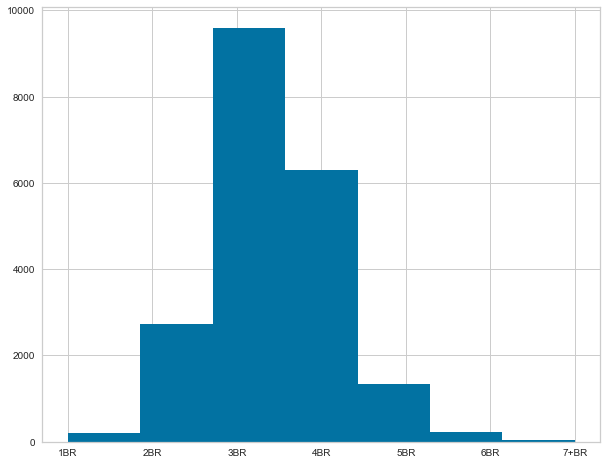

In [12]:
plt.figure(figsize = (10,8))
plt.hist(df.bedrooms_bin.sort_values(),bins = 7);

sqft_basement is an object?

In [13]:
df.sqft_basement.sort_values()

0        0.0
12682    0.0
12685    0.0
12686    0.0
12687    0.0
        ... 
1205       ?
9715       ?
12933      ?
19777      ?
4171       ?
Name: sqft_basement, Length: 20437, dtype: object

sqft_basement is a list of strings that include some unknowns marked as '?'

In [14]:
len(df[df.sqft_basement=='?']) /len(df)

0.02113813181973871

In [15]:
df_subset_basement = df[df.sqft_basement !='?'] #subset of  records where sqft_basement is not '?'
df_subset_basement.sqft_basement = df_subset_basement.sqft_basement.astype(float)

In [16]:
# check to see how much of the current sqft_basement (excluding '?') can be explained by (sqft_living-sqft_above)
living=df_subset_basement.sqft_living
above=df_subset_basement.sqft_above
basement = df_subset_basement.sqft_basement
(living-above == basement).sum() /basement.shape[0]

1.0

So, 98% of the sqft_basement data has a value in it which can be explained using this math. The remaining missing data is filled with '?'. Fill using this math

In [17]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [18]:
#OBSOLETE. Using OneHot Encoding to map these

# # Change view rating to a numeric value. Probably don't need it
# df['view'] = df['view'].map({'EXCELLENT':5,
#                              'GOOD':4,
#                              'AVERAGE':3,
#                              'FAIR':2,
#                              'NONE':1})

# # Change condition rating to a numeric value. Probably don't need it
# df['condition'] = df['condition'].map({'Very Good':5,
#                                        'Good':4,
#                                        'Average':3,
#                                        'Fair':2,
#                                        'Poor':1})

# # Changing grade to just the numeric value of the grade
# df['grade'] = df['grade'].str.split(' ').str[0].astype(int)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20437 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             20437 non-null  int64   
 1   date           20437 non-null  object  
 2   price          20437 non-null  float64 
 3   bedrooms       20437 non-null  int64   
 4   bathrooms      20437 non-null  float64 
 5   sqft_living    20437 non-null  int64   
 6   sqft_lot       20437 non-null  int64   
 7   floors         20437 non-null  float64 
 8   waterfront     18168 non-null  object  
 9   view           20379 non-null  object  
 10  condition      20437 non-null  object  
 11  grade          20437 non-null  object  
 12  sqft_above     20437 non-null  int64   
 13  sqft_basement  20437 non-null  int64   
 14  yr_built       20437 non-null  int64   
 15  yr_renovated   16810 non-null  float64 
 16  zipcode        20437 non-null  int64   
 17  lat            20437 non-null  

In [20]:
#The number of records where view is nan is 0.29% of the dataset. Hence dropped
print(df.view.isna().sum() /df.shape[0])
df.dropna(subset=['view'],inplace=True)

0.002837989920242697


## Analyzing Corelations

In [21]:
df.corr().price.sort_values()

zipcode         -0.018555
id               0.010250
yr_built         0.061387
long             0.072725
sqft_lot15       0.082488
yr_renovated     0.089741
sqft_lot         0.093572
sqft_basement    0.233010
floors           0.273611
bedrooms         0.300831
lat              0.431021
bathrooms        0.455204
sqft_above       0.530569
sqft_living15    0.561947
sqft_living      0.621509
price            1.000000
Name: price, dtype: float64

dropping yr_renovated . not enough records

dropping id, yr_built, floors, date, sqft_lot, sqft_lot15. Not enough correlation. Making predictions based on other columns

stakeholder: potential investor, homebuyer

keeping zipcode, lat, long for the purpose of potential visualizations

In [22]:
df = df.drop(columns = ['id','yr_renovated','floors','date'],axis =1)

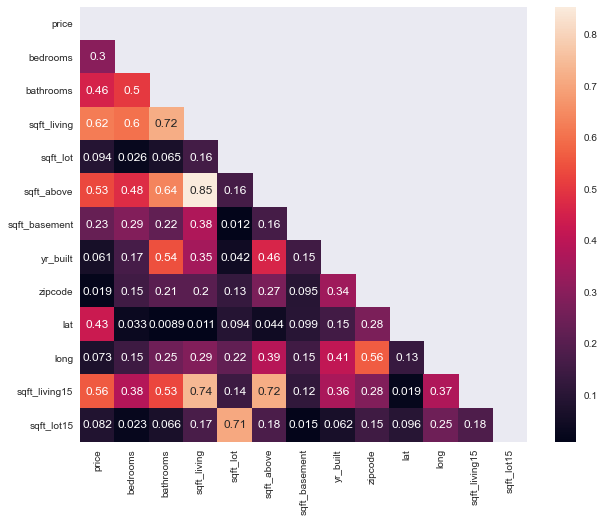

In [23]:
# sns.heatmap(df.corr(),annot=True)
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(10, 8))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    f.savefig('../../images/Corelation Heatmap',bbox_inches="tight")

Note the corelation between
- sqft_living and sqft_above (because sqft_living = sqft_above + sqft_basement). In fact a lot of the sqft are highly corelated
    - try feature engineering between them, or just pick 1 or 2
- grade to sqft_living15, sqft_above
- bathrooms to grade
- grade and sqft_living has highest impact on target (price)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20379 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          20379 non-null  float64 
 1   bedrooms       20379 non-null  int64   
 2   bathrooms      20379 non-null  float64 
 3   sqft_living    20379 non-null  int64   
 4   sqft_lot       20379 non-null  int64   
 5   waterfront     18115 non-null  object  
 6   view           20379 non-null  object  
 7   condition      20379 non-null  object  
 8   grade          20379 non-null  object  
 9   sqft_above     20379 non-null  int64   
 10  sqft_basement  20379 non-null  int64   
 11  yr_built       20379 non-null  int64   
 12  zipcode        20379 non-null  int64   
 13  lat            20379 non-null  float64 
 14  long           20379 non-null  float64 
 15  sqft_living15  20379 non-null  int64   
 16  sqft_lot15     20379 non-null  int64   
 17  bedrooms_bin   20379 non-null  

In [25]:
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
waterfront       2264
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
bedrooms_bin        0
dtype: int64

In [26]:
df.waterfront.isna().sum() / len(df)

0.11109475440404337

We'll have to keep an eye on the waterfront. Maybe drop the values? ~11% of data. Fill with 'NO'

In [27]:
df.waterfront = df.waterfront.fillna('NO')

In [28]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
bedrooms_bin     0
dtype: int64

## Helper Functions

In [29]:
def OHE_scale_lr(X_train, y_train,
                 X_test, y_test,

                 num_col,
                 cat_col=[]
                 ):
    """
    Creates a pipeline to perform a 
    - One-Hot-Encoding (OHE)
    - Standard Scaling
    - Linear Regression

    cat_col = list of categorical column names to process with OHE. default empty list
    num_col = list of numerical column names

    Function applid post train-test split
    """
    if not (cat_col or num_col):
        print("no columns provided to perform operations")
        return None

    # List Comp to get subset of columns
    list_cols = [col 
                 for sublist_cols in [num_col, cat_col]
                 for col in sublist_cols]
    print('Categorical columns:', cat_col, '\nNumerical Columns: ', num_col)

    # Create subsets of train and test sets
    X_train_subset = X_train[list_cols]
    X_test_subset = X_test[list_cols]

    encoder = OneHotEncoder(handle_unknown='error',
                            drop='first',
                            categories='auto')

    scaler = MinMaxScaler(feature_range=(0, 1))

    preprocessor = ColumnTransformer(transformers=[("num", scaler, num_col),
                                                   ("cat", encoder, cat_col)],
                                     remainder='passthrough'
                                     )

    preprocessor.fit(X_train_subset)
    try:
        X_train_enc_arr = preprocessor.transform(X_train_subset).todense()
    except:
        X_train_enc_arr = preprocessor.transform(X_train_subset)
    
    try:
        X_test_enc_arr = preprocessor.transform(X_test_subset).todense()
    except:
        X_test_enc_arr = preprocessor.transform(X_test_subset)

        
    X_train_enc_scaled = pd.DataFrame(X_train_enc_arr, 
                                      columns = preprocessor.get_feature_names_out(),
                                      index = X_train_subset.index
                                     )
    X_test_enc_scaled = pd.DataFrame(X_test_enc_arr, 
                                      columns = preprocessor.get_feature_names_out(),
                                      index = X_test_subset.index
                                     )

        
        
    pipe = make_pipeline(preprocessor, LinearRegression())
    pipe.fit(X_train_subset, y_train)

    train_preds = pipe.predict(X_train_subset)
    test_preds = pipe.predict(X_test_subset)

    print("Training Score:", pipe.score(X_train_subset, y_train))
    print("Test Score:", pipe.score(X_test_subset, y_test))
    
    get_train_test_metrics(y_train, train_preds, y_test, test_preds)

    return X_train_enc_scaled, X_test_enc_scaled, train_preds, test_preds

In [30]:
#OBSOLETE. combined into func above

# def OHEColXFER(cat_col,X_train_subset, X_test_subset):
#     """
#     In place column transformation using One Hot Encoding 
#     """ 
    
#     #Instantiate Encoder
#     encoder = OneHotEncoder(handle_unknown='error',
#                             drop='first',
#                             categories='auto')
    
#     #Instantiate Column Transformer
#     ct = ColumnTransformer(transformers=[('ohe', encoder, cat_col)],
#                            remainder='passthrough')

#     #Fit Column Transformer
#     ct.fit(X_train_subset)

#     #Get your encoded Training and Test sets. Sometimes need to force todens(0) depending upon size of output
#     try:
#         X_train_enc = ct.transform(X_train_subset).todense()
#     except:
#         X_train_enc = ct.transform(X_train_subset)
    
#     try:
#         X_test_enc = ct.transform(X_test_subset).todense()
#     except:
#         X_test_enc = ct.transform(X_test_subset)
    
#     # Get a nice dataframe
#     X_train_enc = pd.DataFrame(X_train_enc, columns=ct.get_feature_names())
#     X_test_enc = pd.DataFrame(X_test_enc, columns=ct.get_feature_names())
    

In [31]:
def get_train_test_metrics(y_train,train_preds,
               y_test,test_preds
              ):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    # R2
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    # R2
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

In [32]:
# def ohe(df, df2, column):    
#     for col in column:
#         train = df[[col]]
#         ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown="error")
#         ohe.fit(train)
#         encoded_train = ohe.transform(train)
#         col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
#         encoded_train = pd.DataFrame(encoded_train,
#                                      columns=col_names, index=df.index)
#         df = pd.concat([df, encoded_train], axis=1)
        
#         test = df2[[col]]
#         encoded_test = ohe.transform(test)
#         col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
#         encoded_test = pd.DataFrame(encoded_test, 
#                                     columns=col_names, index=df2.index)
#         df2 = pd.concat([df2, encoded_test], axis=1)
#     return df, df2, encoded_train.columns.tolist()

## Train Test split

In [33]:
# Define our X and y
X = df.drop(columns='price')
y = df['price']

In [34]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

## Models

### Model 00. Dummy Regressor

In [35]:
dummy = DummyRegressor() #mean strategy

In [36]:
dummy.fit(X_train,y_train)

DummyRegressor()

In [37]:
dummy.score(X_train,y_train)

0.0

In [38]:
dummy.score(X_test,y_test)

-8.727889404758216e-06

Dummy Regressor has a 0 R^2 score?

### Model 0. Using highest corr coefficient feature: sqft_living

In [39]:
df.corr().price.sort_values()[-2:]

sqft_living    0.621509
price          1.000000
Name: price, dtype: float64

In [40]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =[]
                );

Categorical columns: [] 
Numerical Columns:  ['sqft_living']
Training Score: 0.38724291100841735
Test Score: 0.383954425521002

Training Metrics:
R2: 0.387
Mean Absolute Error: 131306.631
Mean Squared Error: 26535522450.985
Root Mean Squared Error: 162897.276

Testing Metrics:
R2: 0.384
Mean Absolute Error: 130433.433
Mean Squared Error: 26429196077.413
Root Mean Squared Error: 162570.588


Any chosen model **should perform better than this**

###  Model 1 : Sqft_living, grade

Note: These should have a high colinearity. Just curious

In [41]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['grade']
                );

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living']
Training Score: 0.4648671683087158
Test Score: 0.4625422103764061

Training Metrics:
R2: 0.465
Mean Absolute Error: 120082.686
Mean Squared Error: 23173994270.670
Root Mean Squared Error: 152230.070

Testing Metrics:
R2: 0.463
Mean Absolute Error: 119705.232
Mean Squared Error: 23057672830.956
Root Mean Squared Error: 151847.532


### Model 2: Sqft_living/Sqft_living15, grade

Feature engineering a ratio of living area to that of the neighborhood. Thinking: biggest house in the neighborhood is a good predicter

In [42]:
X_train['sqft_living/sqft_living15'] = X_train.sqft_living / X_train.sqft_living15
X_test['sqft_living/sqft_living15'] = X_test.sqft_living / X_test.sqft_living15

In [43]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living/sqft_living15'],
                 cat_col =['grade']
                );

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living/sqft_living15']
Training Score: 0.4196360624662394
Test Score: 0.41602860644570516

Training Metrics:
R2: 0.420
Mean Absolute Error: 125151.232
Mean Squared Error: 25132732971.745
Root Mean Squared Error: 158533.066

Testing Metrics:
R2: 0.416
Mean Absolute Error: 124985.048
Mean Squared Error: 25053169932.921
Root Mean Squared Error: 158281.932


yeesh

### Model 3: Sqft_living, Sqft_lot,grade

Trying variations of Sqft_living and Sqft_lot
Thinking: Either individually, an addition or a ratio of the living/lot might be a good predicter

#### Model 3a: Sqft_living, Sqft_lot

In [44]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','sqft_lot'],
                 cat_col =[]
                );

Categorical columns: [] 
Numerical Columns:  ['sqft_living', 'sqft_lot']
Training Score: 0.3872454358288966
Test Score: 0.38399515410064355

Training Metrics:
R2: 0.387
Mean Absolute Error: 131302.720
Mean Squared Error: 26535413113.318
Root Mean Squared Error: 162896.940

Testing Metrics:
R2: 0.384
Mean Absolute Error: 130426.689
Mean Squared Error: 26427448765.750
Root Mean Squared Error: 162565.214


probably also has high multicolinarity. Also, not much better than Model 0

#### Model 3b: Sqft_living + Sqft_lot, grade

In [45]:
X_train['sqft_living + sqft_lot'] = X_train['sqft_living'] + X_train['sqft_lot']
X_test['sqft_living + sqft_lot'] = X_test['sqft_living'] + X_test['sqft_lot']

In [46]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living + sqft_lot'],
                 cat_col =['grade']
                );

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living + sqft_lot']
Training Score: 0.4079769573259925
Test Score: 0.40356186381685866

Training Metrics:
R2: 0.408
Mean Absolute Error: 126169.336
Mean Squared Error: 25637631979.469
Root Mean Squared Error: 160117.557

Testing Metrics:
R2: 0.404
Mean Absolute Error: 126117.183
Mean Squared Error: 25588010209.411
Root Mean Squared Error: 159962.528


#### Model 3c: Sqft_living / Sqft_lot, grade

In [47]:
X_train['sqft_living/sqft_lot'] = X_train['sqft_living'] / X_train['sqft_lot']
X_test['sqft_living/sqft_lot'] = X_test['sqft_living'] / X_test['sqft_lot']

In [48]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living/sqft_lot'],
                 cat_col =['grade']
                );

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living/sqft_lot']
Training Score: 0.41033622239101974
Test Score: 0.40469873178636184

Training Metrics:
R2: 0.410
Mean Absolute Error: 126162.077
Mean Squared Error: 25535463710.467
Root Mean Squared Error: 159798.197

Testing Metrics:
R2: 0.405
Mean Absolute Error: 126204.669
Mean Squared Error: 25539237021.639
Root Mean Squared Error: 159810.003


Feature engineering betwen sqft_living and sqft_lot makes no diff

### Model 4: View, Waterfront, Grade

Something different. No square footage. Based on view, waterfront, grade. Will require little more work, since waterfront has a bunch of nulls

In [49]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = [],
                 cat_col =['view','waterfront','grade']
                );

Categorical columns: ['view', 'waterfront', 'grade'] 
Numerical Columns:  []
Training Score: 0.43041301439845836
Test Score: 0.43331507157385574

Training Metrics:
R2: 0.430
Mean Absolute Error: 123896.487
Mean Squared Error: 24666035719.134
Root Mean Squared Error: 157054.245

Testing Metrics:
R2: 0.433
Mean Absolute Error: 123385.669
Mean Squared Error: 24311556982.055
Root Mean Squared Error: 155921.637


Better, but meh. Marginally better than Model 0

### Model 5: Bedroom, Bathroom, sqft_living

ok. ignoring square footage probably not a good idea. Using room counts as a predicter

#### Model 5a

In [50]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =[]
                );

Categorical columns: [] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'sqft_living']
Training Score: 0.3954060646579909
Test Score: 0.3950108279294229

Training Metrics:
R2: 0.395
Mean Absolute Error: 129877.861
Mean Squared Error: 26182016060.230
Root Mean Squared Error: 161808.578

Testing Metrics:
R2: 0.395
Mean Absolute Error: 128775.430
Mean Squared Error: 25954861321.563
Root Mean Squared Error: 161105.125


#### Model 5b

In [51]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living'],
                 cat_col =['bedrooms_bin']
                );

Categorical columns: ['bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living']
Training Score: 0.3973287992862705
Test Score: 0.397852392603639

Training Metrics:
R2: 0.397
Mean Absolute Error: 129560.556
Mean Squared Error: 26098751796.442
Root Mean Squared Error: 161551.081

Testing Metrics:
R2: 0.398
Mean Absolute Error: 128346.720
Mean Squared Error: 25832954318.164
Root Mean Squared Error: 160726.334


Binning bedrooms has a marginal improvement

### Model 6: Bedroom, Bathroom, sqft_living, grade

#### Model 6a

In [52]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','bedrooms','bathrooms'],
                 cat_col =['grade']
                );

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living', 'bedrooms', 'bathrooms']
Training Score: 0.4674614117485075
Test Score: 0.4648366264961634

Training Metrics:
R2: 0.467
Mean Absolute Error: 119673.272
Mean Squared Error: 23061650233.732
Root Mean Squared Error: 151860.628

Testing Metrics:
R2: 0.465
Mean Absolute Error: 119344.193
Mean Squared Error: 22959239247.428
Root Mean Squared Error: 151523.065


In [53]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living'],
                 cat_col =['grade','bedrooms_bin']
                );

Categorical columns: ['grade', 'bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living']
Training Score: 0.4709729891310259
Test Score: 0.46927766246616276

Training Metrics:
R2: 0.471
Mean Absolute Error: 119076.255
Mean Squared Error: 22909580935.561
Root Mean Squared Error: 151359.112

Testing Metrics:
R2: 0.469
Mean Absolute Error: 118664.878
Mean Squared Error: 22768712742.084
Root Mean Squared Error: 150893.051


Getting better. Seems like better off treating bedrooms as cateogrical.

Hmmm... Including sqft_living AND grade increased scores. But their corelation is high. Probably high multicolinearity. Check a few more models

#### Model 6b: Bedroom/Bathroom, sqft_living, grade

Slight feature engineering. Ratio of bedrooms to bathrooms

In [54]:
X_train['bedrooms/bathrooms'] = X_train['bedrooms']/X_train['bathrooms']
X_test['bedrooms/bathrooms'] = X_test['bedrooms']/X_test['bathrooms']

In [55]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms/bathrooms','sqft_living'],
                 cat_col =['grade']
                );

Categorical columns: ['grade'] 
Numerical Columns:  ['bedrooms/bathrooms', 'sqft_living']
Training Score: 0.4651352462013624
Test Score: 0.4622957990378661

Training Metrics:
R2: 0.465
Mean Absolute Error: 120089.391
Mean Squared Error: 23162385123.968
Root Mean Squared Error: 152191.935

Testing Metrics:
R2: 0.462
Mean Absolute Error: 119751.891
Mean Squared Error: 23068244213.742
Root Mean Squared Error: 151882.337


Not that much better

## Ze Kitchen Sink

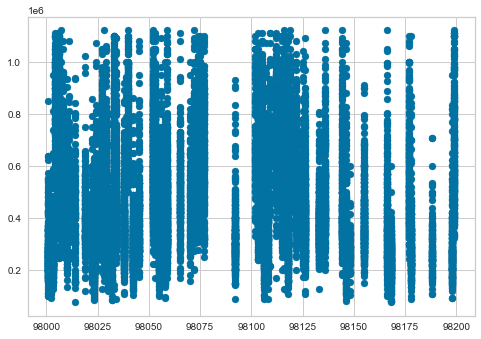

In [56]:
fig, ax = plt.subplots()
ax.scatter(df['zipcode'],df['price'])

If considering zip code, I think it should be considered as a categorical

### Model 7: zipcode included

#### Model 7a

In [57]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['zipcode','sqft_living','bathrooms',],
                 cat_col =['condition','bedrooms_bin',]
                );

Categorical columns: ['condition', 'bedrooms_bin'] 
Numerical Columns:  ['zipcode', 'sqft_living', 'bathrooms']
Training Score: 0.41807267453836305
Test Score: 0.41988591068317516

Training Metrics:
R2: 0.418
Mean Absolute Error: 127075.544
Mean Squared Error: 25200435681.685
Root Mean Squared Error: 158746.451

Testing Metrics:
R2: 0.420
Mean Absolute Error: 126061.119
Mean Squared Error: 24887686315.725
Root Mean Squared Error: 157758.316


#### Model 7b

In [58]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','bathrooms',],
                 cat_col =['bedrooms_bin','zipcode','condition']
                );

Categorical columns: ['bedrooms_bin', 'zipcode', 'condition'] 
Numerical Columns:  ['sqft_living', 'bathrooms']
Training Score: 0.7816866799105303
Test Score: 0.7793184858928225

Training Metrics:
R2: 0.782
Mean Absolute Error: 70556.144
Mean Squared Error: 9454085657.527
Root Mean Squared Error: 97232.123

Testing Metrics:
R2: 0.779
Mean Absolute Error: 70530.559
Mean Squared Error: 9467538196.231
Root Mean Squared Error: 97301.275


PROMISING! 

$_{only~thing~so~far}$

#### Model 7c

In [59]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =['zipcode','condition']
                );

Categorical columns: ['zipcode', 'condition'] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'sqft_living']
Training Score: 0.7802146757403421
Test Score: 0.7776438042988089

Training Metrics:
R2: 0.780
Mean Absolute Error: 70839.793
Mean Squared Error: 9517830982.400
Root Mean Squared Error: 97559.372

Testing Metrics:
R2: 0.778
Mean Absolute Error: 70752.915
Mean Squared Error: 9539384322.636
Root Mean Squared Error: 97669.772


#### Model 7d

In [60]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['zipcode','condition','view','waterfront']
                );

Categorical columns: ['zipcode', 'condition', 'view', 'waterfront'] 
Numerical Columns:  ['sqft_living']
Training Score: 0.7931173026009078
Test Score: 0.7917688580768633

Training Metrics:
R2: 0.793
Mean Absolute Error: 69062.111
Mean Squared Error: 8959081110.899
Root Mean Squared Error: 94652.423

Testing Metrics:
R2: 0.792
Mean Absolute Error: 69274.233
Mean Squared Error: 8933400234.170
Root Mean Squared Error: 94516.666


#### Model 7e

In [61]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =['zipcode','condition','view']
                );

Categorical columns: ['zipcode', 'condition', 'view'] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'sqft_living']
Training Score: 0.7945302524189543
Test Score: 0.7935742182526972

Training Metrics:
R2: 0.795
Mean Absolute Error: 68766.994
Mean Squared Error: 8897893142.139
Root Mean Squared Error: 94328.644

Testing Metrics:
R2: 0.794
Mean Absolute Error: 68947.547
Mean Squared Error: 8855947818.222
Root Mean Squared Error: 94106.046


#### Model 7f

In [62]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living','sqft_living15'],
                 cat_col =['zipcode','condition','view','bedrooms_bin',]
                );

Categorical columns: ['zipcode', 'condition', 'view', 'bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living', 'sqft_living15']
Training Score: 0.8065356057116292
Test Score: 0.8076516480125171

Training Metrics:
R2: 0.807
Mean Absolute Error: 66597.849
Mean Squared Error: 8377999814.827
Root Mean Squared Error: 91531.414

Testing Metrics:
R2: 0.808
Mean Absolute Error: 66378.232
Mean Squared Error: 8252006865.147
Root Mean Squared Error: 90840.557


Best one yet

In [63]:
df.yr_built.isna().sum()

0

#### Model 7g

In [64]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','sqft_living15'],
                 cat_col =['zipcode','condition','view','bedrooms_bin']
                );

Categorical columns: ['zipcode', 'condition', 'view', 'bedrooms_bin'] 
Numerical Columns:  ['sqft_living', 'sqft_living15']
Training Score: 0.8060652678972806
Test Score: 0.8070565871682078

Training Metrics:
R2: 0.806
Mean Absolute Error: 66638.380
Mean Squared Error: 8398367852.760
Root Mean Squared Error: 91642.609

Testing Metrics:
R2: 0.807
Mean Absolute Error: 66438.684
Mean Squared Error: 8277535787.655
Root Mean Squared Error: 90980.964


## Deepdive in Model 7f

Get all the necessary variables (R^2, Condition No, p-values, coeffiencts, intercept)

In [65]:
X_train_xformed, X_test_xformed, train_preds, test_preds = OHE_scale_lr(X_train, y_train,
                                                                        X_test, y_test,
                                                                        num_col=[
                                                                            'bathrooms', 'sqft_living', 'sqft_living15'],
                                                                        cat_col=[
                                                                            'zipcode', 'condition', 'view', 'bedrooms_bin']
                                                                        )

Categorical columns: ['zipcode', 'condition', 'view', 'bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living', 'sqft_living15']
Training Score: 0.8065356057116292
Test Score: 0.8076516480125171

Training Metrics:
R2: 0.807
Mean Absolute Error: 66597.849
Mean Squared Error: 8377999814.827
Root Mean Squared Error: 91531.414

Testing Metrics:
R2: 0.808
Mean Absolute Error: 66378.232
Mean Squared Error: 8252006865.147
Root Mean Squared Error: 90840.557


In [66]:
num_col = ['bathrooms', 'sqft_living', 'sqft_living15']
cat_col = ['zipcode', 'condition', 'view', 'bedrooms_bin', ]

# List Comp to get subset of columns
list_cols = [col
             for sublist_cols in [num_col, cat_col]
             for col in sublist_cols]
# print('Categorical columns:', cat_col, '\nNumerical Columns: ', num_col)

# Create subsets of train and test sets
X_train_subset = X_train[list_cols]
X_test_subset = X_test[list_cols]

encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')

scaler = MinMaxScaler(feature_range=(0, 1))

preprocessor = ColumnTransformer(transformers=[("num", scaler, num_col),
                                               ("cat", encoder, cat_col)],
                                 remainder='passthrough'
                                 )


pipe = make_pipeline(preprocessor, LinearRegression())
pipe.fit(X_train_subset, y_train)

train_preds = pipe.predict(X_train_subset)
test_preds = pipe.predict(X_test_subset)

In [67]:
get_train_test_metrics(y_train,train_preds,y_test,test_preds)


Training Metrics:
R2: 0.807
Mean Absolute Error: 66597.849
Mean Squared Error: 8377999814.827
Root Mean Squared Error: 91531.414

Testing Metrics:
R2: 0.808
Mean Absolute Error: 66378.232
Mean Squared Error: 8252006865.147
Root Mean Squared Error: 90840.557


In [68]:
90840.557/df.price.median()

0.20763555885714285

In [69]:
90840.557/df.price.mean()

0.19056400690343123

Roughly 20% error predicting prices when compared to median house price

### OLS Summary

In [70]:
#Just to get summary
model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_xformed)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     687.3
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        02:36:58   Log-Likelihood:            -1.8321e+05
No. Observations:               14265   AIC:                         3.666e+05
Df Residuals:                   14178   BIC:                         3.673e+05
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.786e+04    1.1e+04      2.536      0.011    6329.832    4.94e+04
num__bathrooms            6.796e+04   1.16e+04      5.871      0.000    4.53e+04    9.07e+04
num__sqft_living          8.882e+05   1.41e+04     62.994      0.000    8.61e+05    9.16e+05
num__sqft_living15        2.876e+05   1.05e+04     27.455      0.000    2.67e+05    3.08e+05
cat__zipcode_98002        1.058e+04   9693.944      1.091      0.275   -8422.665    2.96e+04
cat__zipcode_98003       -1869.8699   8711.816     -0.215      0.830   -1.89e+04    1.52e+04
cat__zipcode_98004         5.11e+05   1.04e+04     49.232      0.000    4.91e+05    5.31e+05
cat__zipcode_98005        3.414e+05    1.1e+04     30.928      0.000     3.2e+05    3.63e+05
cat__zipcode_98006        2.818e+05   8139.612     34.618      0.000    2.66e+05    2.98e+05
cat__zipcode_98007         2.76e+05   1.12e+04     24.629      0.000    2.54e+05    2.98e+05
cat__zipcode_98008        2.478e+05   9104.398     27.218      0.000     2.3e+05    2.66e+05
cat__zipcode_98010        9.386e+04   1.22e+04      7.668      0.000    6.99e+04    1.18e+05
cat__zipcode_98011        1.458e+05   9806.379     14.872      0.000    1.27e+05    1.65e+05
cat__zipcode_98014        1.331e+05   1.12e+04     11.845      0.000    1.11e+05    1.55e+05
cat__zipcode_98019        9.746e+04   9730.203     10.017      0.000    7.84e+04    1.17e+05
cat__zipcode_98022        2.517e+04   9346.277      2.693      0.007    6852.468    4.35e+04
cat__zipcode_98023       -1.719e+04   7596.613     -2.263      0.024   -3.21e+04   -2298.460
cat__zipcode_98024        1.841e+05   1.45e+04     12.704      0.000    1.56e+05    2.13e+05
cat__zipcode_98027        1.993e+05   8172.720     24.392      0.000    1.83e+05    2.15e+05
cat__zipcode_98028        1.338e+05   8691.693     15.393      0.000    1.17e+05    1.51e+05
cat__zipcode_98029        2.457e+05   8452.424     29.074      0.000    2.29e+05    2.62e+05
cat__zipcode_98030        1319.6180   8967.423      0.147      0.883   -1.63e+04    1.89e+04
cat__zipcode_98031         1.15e+04   9015.407      1.275      0.202   -6174.390    2.92e+04
cat__zipcode_98032        5259.9864   1.13e+04      0.465      0.642   -1.69e+04    2.74e+04
cat__zipcode_98033        3.274e+05   8187.544     39.993      0.000    3.11e+05    3.43e+05
cat__zipcode_98034        1.907e+05   7560.899     25.223      0.000    1.76e+05    2.06e+05
cat__zipcode_98038          3.8e+04   7401.443      5.134      0.000    2.35e+04    5.25e+04
cat__zipcode_98039        6.526e+05   5.34e+04     12.226      0.000    5.48e+05    7.57e+05
cat__zipcode_98040        4.263e+05   1.04e+04     41.008      0.000    4.06e+05    4.47e+05
cat__zipcode_98042        1.111e+04   7443.886      1.492      0.136   -3481.883    2.57e+04
cat__zipcode_9

Makes intuitive sense. Some zip codes have a much higher impact on prices. pricier neighborhoods

In [71]:
model.params

const                      27860.795472
num__bathrooms             67963.064185
num__sqft_living          888157.553427
num__sqft_living15        287613.126738
cat__zipcode_98002         10578.738217
                              ...      
cat__bedrooms_bin_3BR      14040.741392
cat__bedrooms_bin_4BR       7334.521887
cat__bedrooms_bin_5BR     -20255.955927
cat__bedrooms_bin_6BR     -44380.273211
cat__bedrooms_bin_7+BR    -90837.263538
Length: 87, dtype: float64

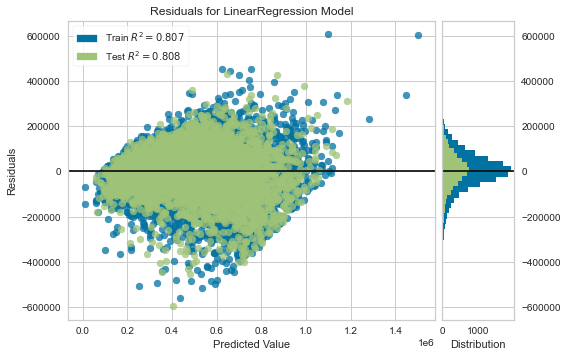

In [72]:
# visualizing our residuals 
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_xformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_xformed, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

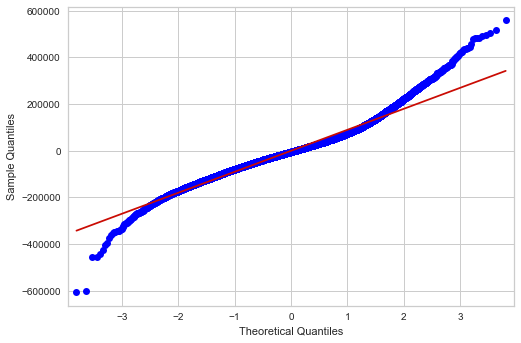

In [73]:
sm.qqplot(y_train-train_preds, line = 'r');

## LOG (Price)

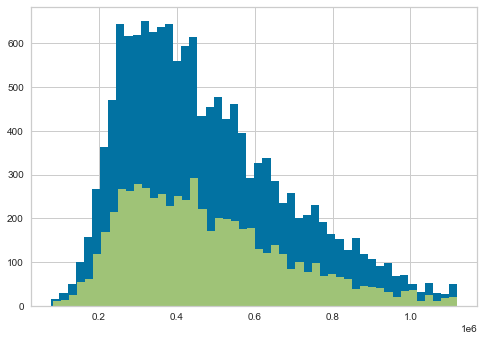

In [74]:
plt.hist(y_train,bins = 50)
plt.hist(y_test,bins = 50);

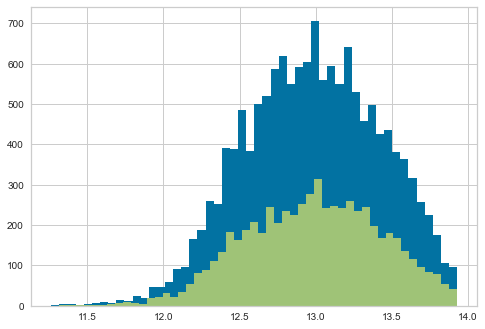

In [75]:
plt.hist(np.log(y_train),bins = 50)
plt.hist(np.log(y_test),bins = 50);

In [76]:
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

X_train_xformed, X_test_xformed, train_preds, test_preds = OHE_scale_lr(X_train, log_y_train,
                                                                        X_test, log_y_test,
                                                                        num_col=[
                                                                            'bathrooms', 'sqft_living', 'sqft_living15'],
                                                                        cat_col=[
                                                                            'zipcode', 'condition', 'view', 'bedrooms_bin']
                                                                        )

Categorical columns: ['zipcode', 'condition', 'view', 'bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living', 'sqft_living15']
Training Score: 0.8189234720834138
Test Score: 0.8178415326133166

Training Metrics:
R2: 0.819
Mean Absolute Error: 0.139
Mean Squared Error: 0.036
Root Mean Squared Error: 0.190

Testing Metrics:
R2: 0.818
Mean Absolute Error: 0.139
Mean Squared Error: 0.036
Root Mean Squared Error: 0.190


In [77]:
np.exp(0.190)

1.2092495976572515

$1.20? Doesn't sound right

In [78]:
train_residuals = log_y_train - train_preds
test_residuals = log_y_test - test_preds

In [79]:
get_train_test_metrics(np.exp(log_y_train),np.exp(train_preds),
                      np.exp(log_y_test),np.exp(test_preds))


Training Metrics:
R2: 0.776
Mean Absolute Error: 65635.002
Mean Squared Error: 9720975122.556
Root Mean Squared Error: 98595.006

Testing Metrics:
R2: 0.793
Mean Absolute Error: 64959.771
Mean Squared Error: 8881355310.103
Root Mean Squared Error: 94240.943


that RMSE is more likely

In [80]:
#Just to get summary
model = sm.OLS(endog=log_y_train, exog=sm.add_constant(X_train_xformed)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     745.6
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        02:36:59   Log-Likelihood:                 3481.6
No. Observations:               14265   AIC:                            -6789.
Df Residuals:                   14178   BIC:                            -6131.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       11.8698      0.023    521.761      0.000      11.825      11.914
num__bathrooms               0.2976      0.024     12.411      0.000       0.251       0.345
num__sqft_living             1.6695      0.029     57.176      0.000       1.612       1.727
num__sqft_living15           0.6102      0.022     28.124      0.000       0.568       0.653
cat__zipcode_98002          -0.0398      0.020     -1.980      0.048      -0.079      -0.000
cat__zipcode_98003           0.0208      0.018      1.153      0.249      -0.015       0.056
cat__zipcode_98004           1.0333      0.021     48.069      0.000       0.991       1.075
cat__zipcode_98005           0.7450      0.023     32.589      0.000       0.700       0.790
cat__zipcode_98006           0.6440      0.017     38.202      0.000       0.611       0.677
cat__zipcode_98007           0.6847      0.023     29.500      0.000       0.639       0.730
cat__zipcode_98008           0.6475      0.019     34.342      0.000       0.611       0.685
cat__zipcode_98010           0.2695      0.025     10.632      0.000       0.220       0.319
cat__zipcode_98011           0.4418      0.020     21.752      0.000       0.402       0.482
cat__zipcode_98014           0.3599      0.023     15.463      0.000       0.314       0.406
cat__zipcode_98019           0.3225      0.020     16.004      0.000       0.283       0.362
cat__zipcode_98022           0.0889      0.019      4.591      0.000       0.051       0.127
cat__zipcode_98023          -0.0259      0.016     -1.648      0.099      -0.057       0.005
cat__zipcode_98024           0.4758      0.030     15.851      0.000       0.417       0.535
cat__zipcode_98027           0.5187      0.017     30.646      0.000       0.486       0.552
cat__zipcode_98028           0.4106      0.018     22.810      0.000       0.375       0.446
cat__zipcode_98029           0.6282      0.018     35.886      0.000       0.594       0.663
cat__zipcode_98030           0.0350      0.019      1.885      0.059      -0.001       0.071
cat__zipcode_98031           0.0711      0.019      3.807      0.000       0.034       0.108
cat__zipcode_98032          -0.0137      0.023     -0.583      0.560      -0.060       0.032
cat__zipcode_98033           0.7566      0.017     44.619      0.000       0.723       0.790
cat__zipcode_98034           0.5210      0.016     33.269      0.000       0.490       0.552
cat__zipcode_98038           0.1626      0.015     10.607      0.000       0.133       0.193
cat__zipcode_98039           1.2906      0.111     11.675      0.000       1.074       1.507
cat__zipcode_98040           0.8562      0.022     39.769      0.000       0.814       0.898
cat__zipcode_98042           0.0595      0.015      3.861      0.000       0.029       0.090
cat__zipcode_9

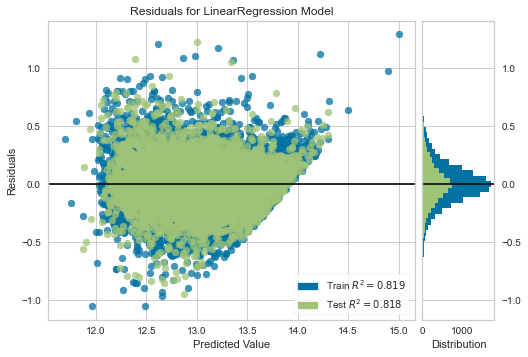

In [81]:
# visualizing our residuals 
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_xformed, log_y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_xformed, log_y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

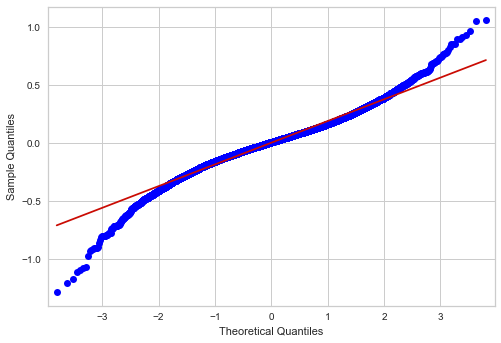

In [82]:
sm.qqplot(train_residuals, line = 'r');

WORSE!

## FINAL MODEL

In [100]:
num_col = ['bathrooms', 'sqft_living', 'sqft_living15']
cat_col = ['zipcode', 'condition', 'view', 'bedrooms_bin']
list_cols = [col
             for sublist_cols in [num_col, cat_col]
             for col in sublist_cols]

In [101]:
list_cols

['bathrooms',
 'sqft_living',
 'sqft_living15',
 'zipcode',
 'condition',
 'view',
 'bedrooms_bin']

In [102]:
X = pd.concat([X_train,X_test]).sort_index()[list_cols]
y = pd.concat([y_train,y_test]).sort_index() 


In [105]:
X_potentials = pd.DataFrame(columns=X.columns)
for num in range(0,3):
    X_potentials = X_potentials.append(
    pd.Series(0, index=X_potentials.columns), 
    ignore_index=True)
    
y_empty = pd.DataFrame(index=X_potentials.index,columns = ['price'])
y_empty.fillna(0,inplace=True)

In [108]:
#Creating a potential feature matrix
#Filling these with median/most common home features
X_potentials.bathrooms.replace(0,df.bathrooms.value_counts().index[0],inplace=True)
X_potentials.sqft_living.replace(0,df['sqft_living'].median(),inplace=True)
X_potentials.sqft_living15.replace(0,df['sqft_living15'].median(),inplace=True)
X_potentials.zipcode.replace(0,df.zipcode.value_counts().index[0],inplace=True)
X_potentials.condition.replace(0,df.condition.value_counts().index[0],inplace=True)
X_potentials.view.replace(0,df.view.value_counts().index[0],inplace=True)
X_potentials.bedrooms_bin.replace(0,df.bedrooms_bin.value_counts().index[0],inplace=True)


In [109]:
X_potentials.bathrooms = [1,2,2.5]

In [110]:
X_potentials

,bathrooms,sqft_living,sqft_living15,zipcode,condition,view,bedrooms_bin
0,1.0,1860.0,1800.0,98103,Average,NONE,3BR
1,2.0,1860.0,1800.0,98103,Average,NONE,3BR
2,2.5,1860.0,1800.0,98103,Average,NONE,3BR


In [113]:
X_xformed, X_potential_xformed, X_preds, potential_preds = OHE_scale_lr(X, y,
                                                                        X_potentials, y_empty,
                                                                        num_col=[
                                                                            'bathrooms', 'sqft_living', 'sqft_living15'],
                                                                        cat_col=[
                                                                            'zipcode', 'condition', 'view', 'bedrooms_bin']
                                                                        )

Categorical columns: ['zipcode', 'condition', 'view', 'bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living', 'sqft_living15']
Training Score: 0.8071957746986202
Test Score: 0.0

Training Metrics:
R2: 0.807
Mean Absolute Error: 66497.449
Mean Squared Error: 8326071130.754
Root Mean Squared Error: 91247.308

Testing Metrics:
R2: 0.000
Mean Absolute Error: 603603.479
Mean Squared Error: 364375880659.399
Root Mean Squared Error: 603635.553


In [114]:
potential_preds

array([595288.11469076, 605266.55130914, 610255.76961833])

## Some weird plots

In [ ]:
df_pairplotting1 = df.filter(['bedrooms','bathrooms','floors','view','condition','price'])
df_pairplotting2 = df.filter(['bedrooms','sqft_living', 'sqft_lot','sqft_above','sqft_living15', 'sqft_lot15','price'])

In [ ]:
sns.pairplot(df_pairplotting1)

In [ ]:
sns.pairplot(df_pairplotting2)